In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("precision", 2)
pd.options.display.float_format = '{:20,.2f}'.format

%matplotlib inline

# NYC Restaurants dataset

Source: https://data.cityofnewyork.us/Health/Restaurant-Grades/gra9-xbjk/data

In [2]:
df = pd.read_csv("Restaurant_Grades.csv")

# Describe the data
df.head(5)

,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE
0,DARKHORSE,MANHATTAN,17,MURRAY STREET,10007,American,Pesticide use not in accordance with label or ...,Not Critical,13.00,A,5/20/2016,3/18/2018
1,LOTS O BAGELS,QUEENS,3005,BROADWAY,11106,Bagels/Pretzels,Filth flies or food/refuse/sewage-associated (...,Critical,9.00,A,4/2/2015,3/18/2018
2,LOTUS CAFE & BAGELS,BROOKLYN,4,NEPTUNE AVENUE,11235,American,Facility not vermin proof. Harborage or condit...,Not Critical,12.00,A,1/25/2017,3/18/2018
3,SUBWAY,BRONX,1490,BOSTON ROAD,10460,Sandwiches,Food Protection Certificate not held by superv...,Critical,12.00,A,12/27/2017,3/18/2018
4,810 DELI & CAFE,MANHATTAN,810,7 AVENUE,10019,American,Plumbing not properly installed or maintained;...,Not Critical,9.00,A,11/15/2017,3/18/2018


In [3]:
# Replace spaces with underscores
df.columns = df.columns.str.replace("CUISINE DESCRIPTION","CUISINE")
df.columns = df.columns.str.replace(" ","_")

# Clean up some of the names
df["DBA"].replace("'","", inplace=True) # Remove apostrophe
df["DBA"].replace(" ?\(.+\)", "", regex=True, inplace=True) # Remove values in parenthesis
df["DBA"].replace(" ?#.*", "", regex=True, inplace=True) # Remove # followed by some string

# Convert dates to datetime
df.GRADE_DATE = pd.to_datetime(df.GRADE_DATE, format="%m/%d/%Y")
df.RECORD_DATE = pd.to_datetime(df.RECORD_DATE, format="%m/%d/%Y")

# Create a unique key based on restaurant
df["KEY"] = df[['DBA', 'BUILDING', "STREET", "ZIPCODE"]].astype(str).apply(lambda x: ' '.join(x), axis=1)
print("num ratings: {} num unique restaurants: {}".format(len(df), len(df.KEY.unique())))
df[["KEY"]].head(5)

num ratings: 186185 num unique restaurants: 24607


,KEY
0,DARKHORSE 17 MURRAY STREET 10007
1,LOTS O BAGELS 3005 BROADWAY 11106
2,LOTUS CAFE & BAGELS 4 NEPTUNE AVENUE 11235
3,SUBWAY 1490 BOSTON ROAD 10460
4,810 DELI & CAFE 810 7 AVENUE 10019


In [4]:
# Scores are broken down by critical, not critical and not applicable, which results in duplicate rows for the same rating
df = df[["KEY","DBA","BORO","CUISINE","SCORE","GRADE","GRADE_DATE","RECORD_DATE"]].drop_duplicates()
df = df.sort_values(["KEY","GRADE_DATE"],ascending=[True,False])

## What is the breakdown of the ratings?

The score is from 0 up. Low score is good as it indicates no violations. Each violation has some point value so a score of 0 means there are no violations. There are three types of violations:

1.	General – e.g. not properly santizing cooking utensiles – min 2 points
2.	Critical – e.g. serving raw food such as a salad without properly washing it first – min 5 points
3.	Public Health Hazard – e.g. failing to keep food at right temperature – min 7 points

The final grade is based on the sum of all the points. A score of 0 to 13 earns an A. 14 to 27 earns a B and 28 or more earns a C. Below is a breakdown of the ratings


,count all,perc all,count most recent,perc most recent
GRADE,,,,
A,"70,856.00",87.25,"22,017.00",89.47
B,"6,721.00",8.28,"1,357.00",5.51
C,"1,466.00",1.81,259.00,1.05
Not Yet Graded,2.00,0.00,2.00,0.01
P,"1,193.00",1.47,nan,nan
Z,972.00,1.20,972.00,3.95


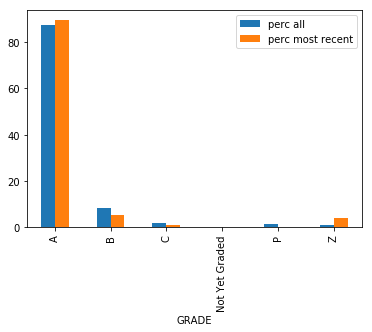

In [5]:
gb_all = df.groupby("GRADE").GRADE.agg(["count"])
gb_all["perc"] = gb_all / gb_all.sum() * 100

gb_recent = df.drop_duplicates("KEY").groupby("GRADE").GRADE.agg(["count"])
gb_recent["perc"] = gb_recent / gb_recent.sum() * 100

gb_all = gb_all.join(gb_recent,lsuffix=" all", rsuffix=" most recent")#

gb_all[["perc all", "perc most recent"]].plot(kind="bar")
gb_all.style.format("{:,.2f}")

I’m not surprised that the majority of grades are As with less that 2% of inspections resulting in a C grade. How about the distribution of the points?

In [6]:
# Define colors to be used in visualizations
colors = {"A": "darkseagreen", "B": "dodgerblue", "C": "lightcoral", "P": "wheat", "Z": "lightgrey", "Not Yet Graded": "lightgrey"}

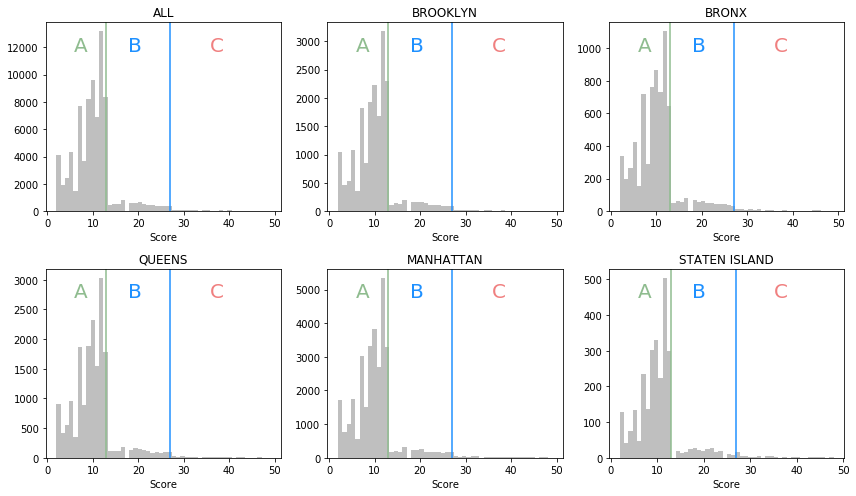

In [7]:
# Bar graph based on scores, segmented by grade
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,7))

axes[0][0].hist(df[(df.SCORE > 0) & (df.SCORE < 50)].SCORE,bins=50, color="grey",alpha=0.5)
axes[0][0].set_title("ALL")

for ax, boro in zip(axes.ravel()[1:], df.BORO.unique()):
    ax.hist(df[(df.SCORE > 0) & (df.SCORE < 50) & (df.BORO == boro)].SCORE,bins=50, color="grey",alpha=0.5)
    ax.set_title(boro)
    
for ax in axes.ravel():
    ax.axvline(13,color=colors["A"],linestyle="-")
    ax.text(0.12, 0.85,"A",color=colors["A"],transform=ax.transAxes,fontsize=20)
    ax.axvline(27,color=colors["B"],linestyle="-")
    ax.text(0.35, 0.85,"B",color=colors["B"],transform=ax.transAxes,fontsize=20)
    ax.text(0.7, 0.85,"C",color=colors["C"],transform=ax.transAxes,fontsize=20)
    ax.set_xlabel("Score")
    
plt.tight_layout()

In [8]:
df[(df.SCORE > 0) & (df.SCORE < 16)].groupby("SCORE").SCORE.agg("count")

SCORE
 2.00     4121
 3.00     1883
 4.00     2444
 5.00     4328
 6.00     1482
 7.00     7684
 8.00     3652
 9.00     8189
10.00     9566
11.00     6888
12.00    13156
13.00     8322
14.00      474
15.00      528
Name: SCORE, dtype: int64

There seems to be a steep drop-off on 14 points. My guess is that inspectors show leniency when nearing the cut-off threshold. If it’s close, they give the owner the benefit of receiving the higher grade since the letter grade is the most visible component to the customer. Another, less plausible explanation, is that restaurants understand there is some leniency with certain violations, so they allow themselves some violations while maintaining an A grade. Also, note that the cut-off exists from B to C grade as well, although it’s a steady decline leading up to the C score.

## When do the inspectors come?

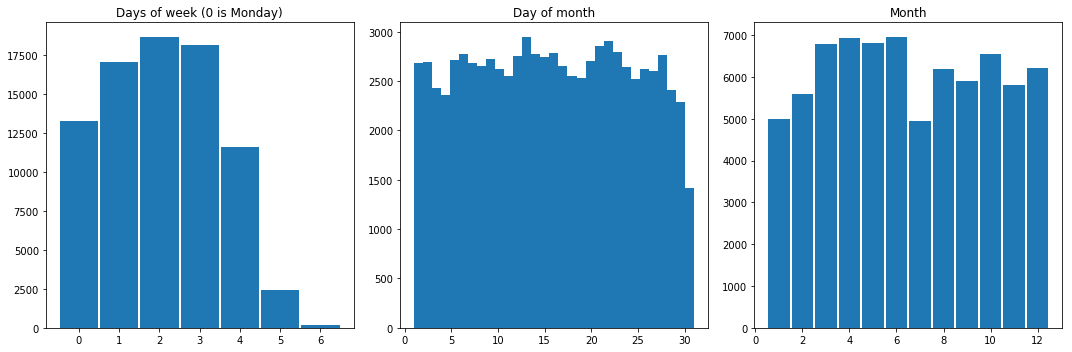

In [9]:
f, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

_ = axes[0].hist(df.GRADE_DATE.dt.dayofweek, bins=np.arange(8)-0.5, rwidth=0.95)
axes[0].set_title("Days of week (0 is Monday)")
_ = axes[1].hist(df.GRADE_DATE.dt.day, bins=31)
axes[1].set_title("Day of month")
_ = axes[2].hist(df[df.GRADE_DATE.dt.year < 2018].GRADE_DATE.dt.month, bins=np.arange(1,14)-0.5, rwidth=0.9)
axes[2].set_title("Month")

f.tight_layout()


Looks like food inspectors don't like working weekends, especially Sundays. Oh, and they also take it easy in July

## Has there been grade inflation?

Text(0.5,1,'Ratings over time')

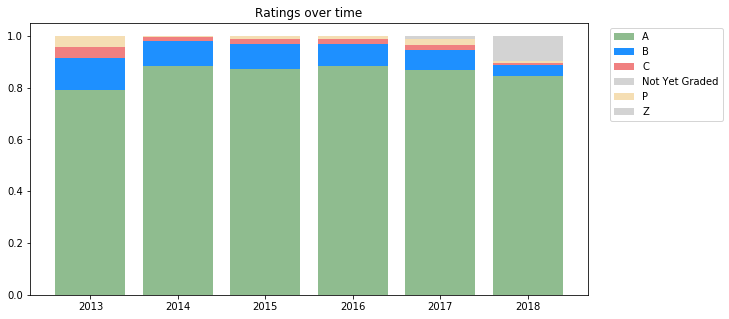

In [10]:
f, ax = plt.subplots(figsize=(10,5))

df["YEAR"] = df.GRADE_DATE.dt.year

gb = df[["YEAR", "GRADE","SCORE"]].groupby(["YEAR","GRADE"]).agg("count")
gb["perc"] = gb / gb.sum(level=0)

for year in df.YEAR.unique():
    bottom = 0
    for grade in sorted(df.GRADE.unique()):
        perc = gb[(gb.index.get_level_values(0) == year) & (gb.index.get_level_values(1) == grade)].perc
        if len(perc) > 0:
            perc = perc.values[0]
            ax.bar(year, perc, bottom=bottom, color=colors[grade])
            bottom += perc

ax.legend(sorted(df.GRADE.unique()), bbox_to_anchor=(1.25,1), loc="upper right")
ax.set_title("Ratings over time")

No

## What restaurant chains have the best rating for their cuisine?

In [11]:
# Replace cuisine description of each restaurant with most common
most_common_cuisine = df.groupby(["DBA"])["CUISINE"].agg(lambda x: x.value_counts().index[0])
df = df.drop("CUISINE",axis=1)
df = df.join(most_common_cuisine, on="DBA")

In [12]:
# Calculate how many times each restaurant chain was graded
num_score_dba = df.groupby("DBA")[["SCORE"]].count()
num_score_dba.columns = ["NUM_SCORE_DBA"]

mean_score_dba = df.groupby("DBA")[["SCORE"]].mean()
mean_score_dba.columns = ["MEAN_SCORE_DBA"]

mean_score_dba = df.groupby("DBA")[["SCORE"]].median()
mean_score_dba.columns = ["MED_SCORE_DBA"]

max_score_dba = df.groupby("DBA")[["SCORE"]].max()
max_score_dba.columns = ["MAX_SCORE_DBA"]

min_score_dba = df.groupby("DBA")[["SCORE"]].min()
min_score_dba.columns = ["MIN_SCORE_DBA"]

std_score_dba = df.groupby("DBA")[["SCORE"]].std()
std_score_dba.columns = ["STD_SCORE_DBA"]

for field in [num_score_dba, mean_score_dba, min_score_dba, max_score_dba, std_score_dba]:
    df = df.join(field, on="DBA")

In [13]:
# Update the dataframe with percentage breakdown of each grade
grade_dba = df.groupby(["DBA","GRADE"]).agg({'GRADE': 'count'})
grade_dba = grade_dba.groupby(level=0).apply(lambda x: x / float(x.sum()))

for grade in grade_dba.index.get_level_values("GRADE").unique():
    _grade_dba = grade_dba[grade_dba.index.get_level_values("GRADE") == grade]
    _grade_dba.index = _grade_dba.index.droplevel(level="GRADE")
    df = df.join(_grade_dba, on="DBA", rsuffix="_{}".format(grade))
    df["GRADE_{}".format(grade)].fillna(0, inplace = True)

In [14]:
df[df.NUM_SCORE_DBA > 50].sort_values(["CUISINE", "GRADE_A"], ascending=[True,False]).groupby(
    ["CUISINE","DBA", "GRADE_A", "GRADE_C", "MED_SCORE_DBA", "MAX_SCORE_DBA"], sort=False)[["SCORE"]].count()

SCORE
CUISINE                         DBA                                   GRADE_A GRADE_C MED_SCORE_DBA MAX_SCORE_DBA       
American                        APPLEBEE'S                            1.00    0.00     8.00         13.00             92
                                PANERA BREAD                          1.00    0.00    10.00         13.00             60
                                SHAKE SHACK                           0.97    0.00     9.50         18.00             60
                                BOSTON MARKET                         0.96    0.01    10.00         20.00             71
                                CHECKERS                              0.94    0.00    10.00         26.00            111
                                AMC THEATRES                          0.91    0.02     9.50         45.00             56
Bagels/Pretzels                 AUNTIE ANNE'S PRETZELS                1.00    0.00     7.00         13.00             64
CafÃ©/Coffee/Tea                STARBUCKS                             0.99    0.00     5.00         27.00            954
                                STARBUCKS COFFEE                      0.99    0.00     6.50         17.00            104
                                VIVI BUBBLE TEA                       0.90    0.02     8.00         38.00             58
Caribbean                       GOLDEN KRUST CARIBBEAN BAKERY & GRILL 0.88    0.03    10.00         46.00            182
Chicken                         POPEYES LOUISIANA KITCHEN             0.94    0.00     9.00         32.00            257
                                KFC                                   0.92    0.01    10.00         36.00            132
                                KENNEDY FRIED CHICKEN                 0.88    0.02    10.00         51.00            285
                                CROWN FRIED CHICKEN                   0.83    0.01    10.00         43.00            208
Donuts                          DUNKIN DONUTS                         1.00    0.00     7.00         13.00             89
                                DUNKIN' DONUTS                        0.96    0.01     8.00         41.00           1489
                                DUNKIN' DONUTS, BASKIN ROBBINS        0.95    0.00     9.00         36.00            431
Hamburgers                      WHITE CASTLE                          1.00    0.00     7.00         13.00             76
                                FIVE GUYS FAMOUS BURGERS AND FRIES    0.99    0.00     9.00         20.00             73
                                WENDY'S                               0.97    0.00     9.00         21.00            151
                                MCDONALD'S                            0.97    0.01     9.00         62.00            710
                                BURGER KING                           0.92    0.01     9.00         36.00            275
                                BAREBURGER                            0.90    0.01     9.50         27.00             70
Ice Cream, Gelato, Yogurt, Ices CARVEL ICE CREAM                      0.95    0.00     9.00         23.00            109
Mexican                         CHIPOTLE MEXICAN GRILL                0.95    0.01     9.00         41.00            261
Pancakes/Waffles                IHOP                                  0.96    0.01    10.50         41.00             74
Pizza                           LITTLE CAESARS                        0.97    0.00     9.00         21.00            117
                                PIZZA HUT                             0.95    0.02     7.00         30.00             64
                                PAPA JOHN'S                           0.94    0.00     8.00         25.00            130
                                DOMINO'S                              0.81    0.05    10.00         53.00            306
Salads                          CHOP'T                                1.00    0.00     9.00         13.00             56
 

The ratings are surprisingly good, but I suppose that’s expected for large chains. Remember that a high score is bad. Some establishments like Applebee’s, Panera Bread and White Castle (!) have never received a grade other than A. Other groups like Domino’s are very inconsistent and often bad (only 81% of their grades received are As and 5% are Cs). 

## Probability of transitioning from one state to the other (roll rates)

In [15]:
max_num_ratings = max(df.groupby("KEY").size())
columns = [idx for idx in range(max_num_ratings)]
columns.insert(0, "KEY")
df_rest = pd.DataFrame(columns=columns)

for key in df.KEY.unique():
    df_key = df[df.KEY == key]
    new_row = {col: "NA" for col in columns}
    new_row = {"KEY": key}
    for idx, (k, v) in enumerate(df_key.iterrows()):
        new_row[idx] = v.GRADE
    
    df_rest = pd.concat([df_rest, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    
df_rolls = pd.DataFrame(columns=[1,2])
for c1 in range(max_num_ratings - 2):
    c2 = c1 +  1
    df_rest_valid = df_rest[(~df_rest[c1].isna()) & (~df_rest[c2].isna())]
    df_roll = pd.concat([df_rest_valid[c1], df_rest_valid[c2]], axis=1)
    df_roll.columns = [1,2]
    df_rolls = pd.concat([df_rolls, df_roll], ignore_index=True)
    
df_rolls.head()

,1,2
0,A,A
1,A,A
2,A,B
3,A,A
4,A,A


In [16]:
states = ["A","B","C","P","Z"]
df_roll_rates = pd.DataFrame(np.zeros([5,5]), columns=states, index=states)
for s1 in states:
    for s2 in states:
        num_match = sum((df_rolls[1] == s1) & (df_rolls[2] == s2))
        num_all = sum(df_rolls[1] == s1)
        if num_all > 0:
            df_roll_rates.loc[s2,s1] = num_match / num_all

df_roll_rates.columns.name = "from"
df_roll_rates.index.name = "to"

df_roll_rates * 100


from,A,B,C,P,Z
to,,,,,
A,88.74,68.59,66.87,80.18,69.10
B,7.78,21.62,22.32,15.15,20.87
C,1.68,4.93,7.11,4.67,4.95
P,1.80,4.86,3.70,0.00,5.07
Z,0.00,0.00,0.00,0.00,0.00


## How long do restaurants stay at a given grade?

In [17]:
# Create next grade date
df["NEXT_GRADE_DATE"] = df.GRADE_DATE.shift()

# Remove next grade date for most recent grades
df.loc[df.drop_duplicates("KEY").index,"NEXT_GRADE_DATE"] = pd.NaT

df["TIME_AT_GRADE"] = df.NEXT_GRADE_DATE - df.GRADE_DATE

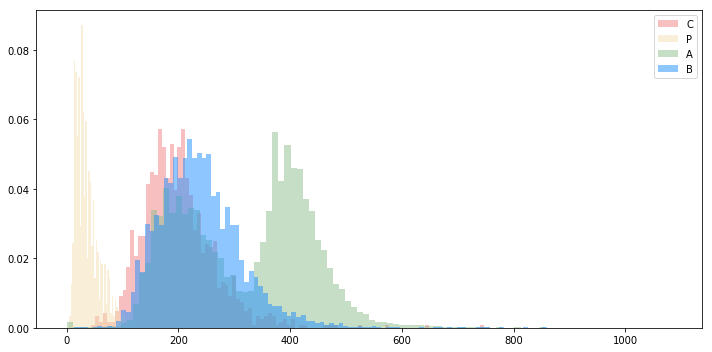

In [18]:
f, ax = plt.subplots(figsize=(10,5))

for grade, color in colors.items():
    days_at_grade = df[(~df.TIME_AT_GRADE.isna()) & (df.GRADE == grade)].TIME_AT_GRADE.dt.days
    if days_at_grade.size > 0:
        ax.hist(days_at_grade, color=color, label=grade, alpha=0.5, bins=100, weights=np.zeros_like(days_at_grade) + 1. / days_at_grade.size)
ax.legend()
f.tight_layout()

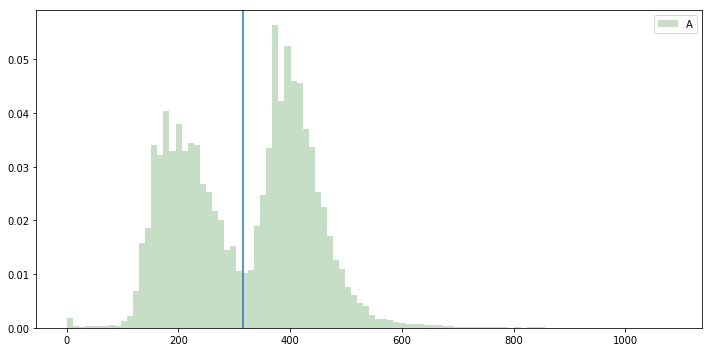

In [19]:
f, ax = plt.subplots(figsize=(10,5))

a_grades = df[(~df.TIME_AT_GRADE.isna()) & (df.GRADE == "A")]
days_at_grade = a_grades.TIME_AT_GRADE.dt.days
ax.hist(days_at_grade, color=colors["A"], label="A", alpha=0.5, bins=100, weights=np.zeros_like(days_at_grade) + 1. / days_at_grade.size)
ax.axvline(315)

ax.legend()
f.tight_layout()

### Bi-modal over the years?

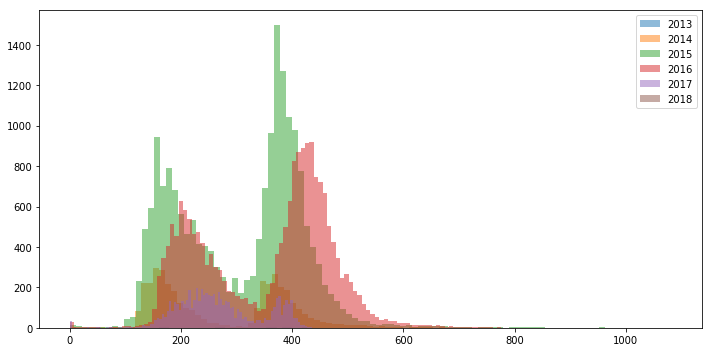

In [20]:
f, ax = plt.subplots(figsize=(10,5))

for year in sorted(a_grades.GRADE_DATE.dt.year.unique()):
    days_at_grade = a_grades[a_grades.GRADE_DATE.dt.year == year].TIME_AT_GRADE.dt.days
    ax.hist(days_at_grade, label=str(year), alpha=0.5, bins=100)

ax.legend()
f.tight_layout()

Length of A grades has always been bi-modal

### Bi-modal across cusine types?

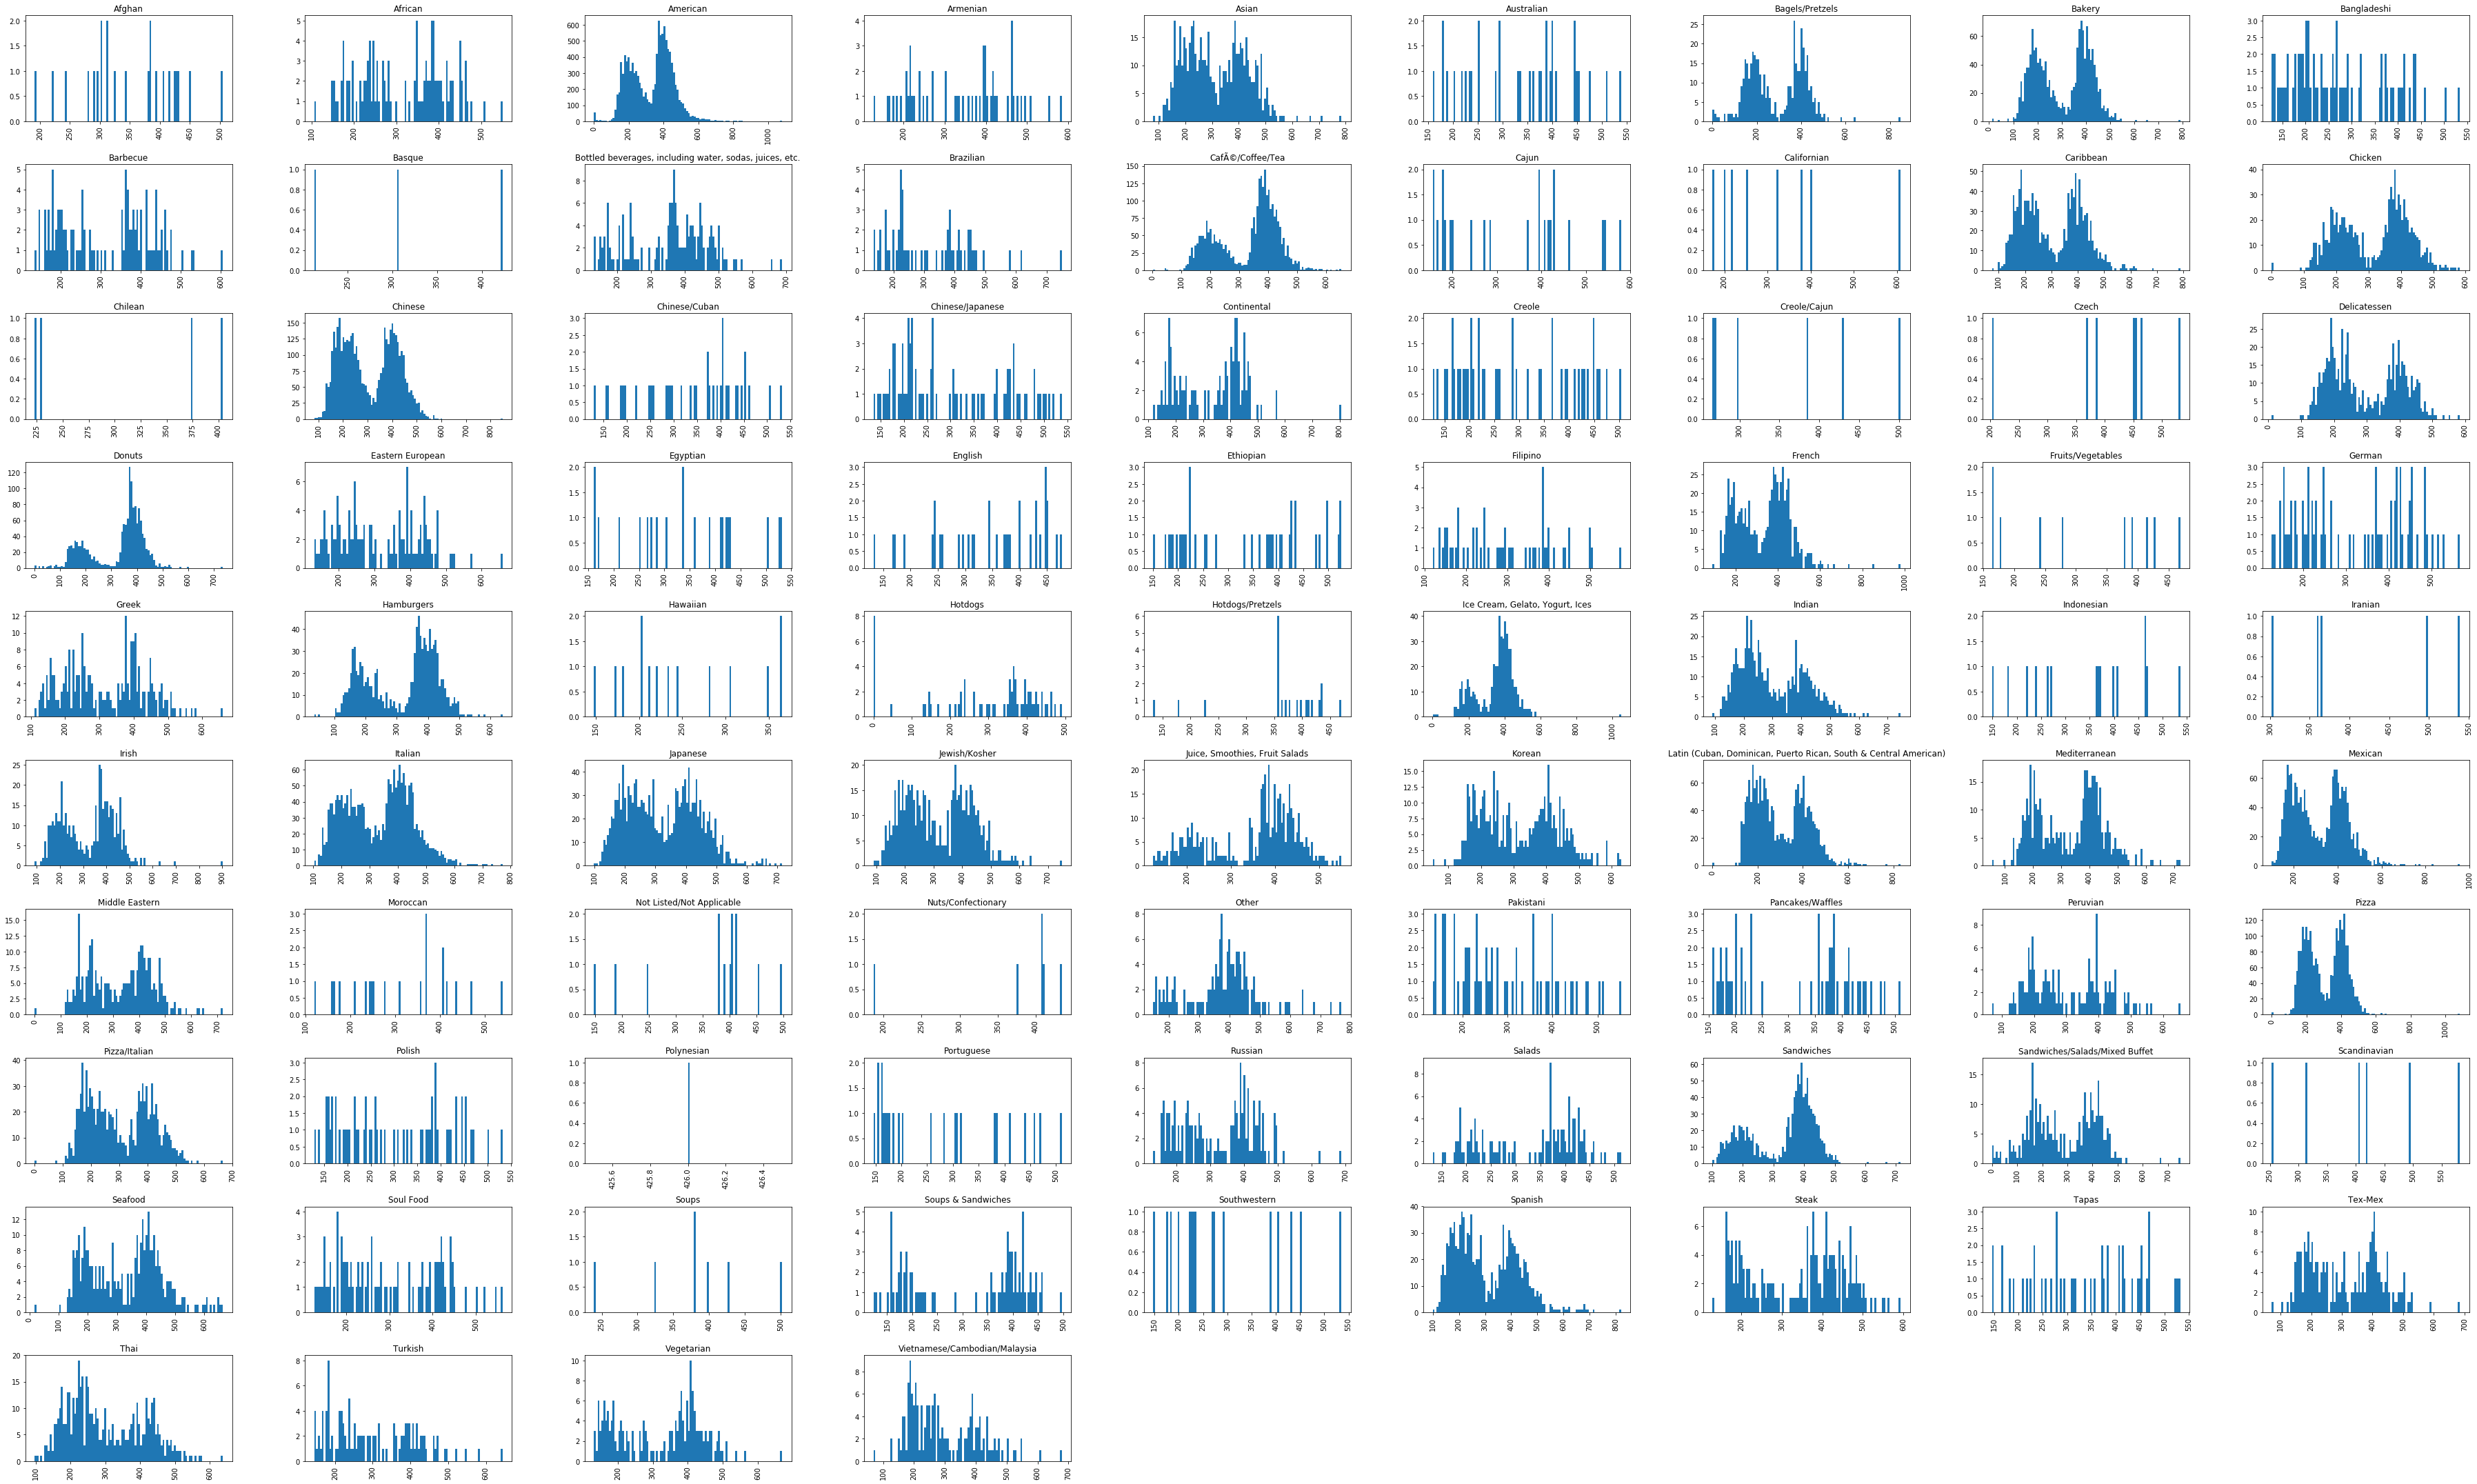

In [21]:
_ = a_grades.TIME_AT_GRADE.dt.days.hist(by=a_grades.CUISINE, bins=100, figsize=(50,30))
plt.tight_layout()

For the most part, yes

### Bi-modal across boros?

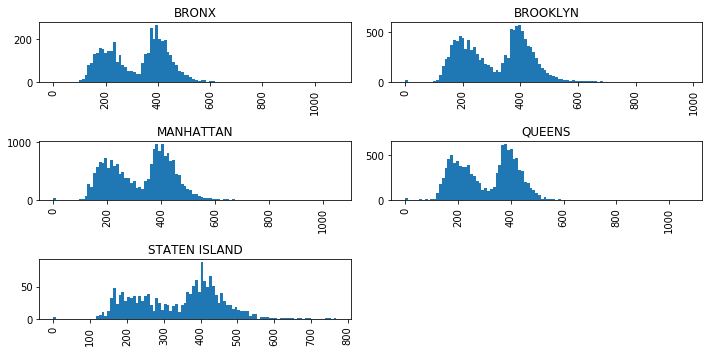

In [22]:
ax = a_grades.TIME_AT_GRADE.dt.days.hist(by=a_grades.BORO, bins=100, figsize=(10,5))

plt.tight_layout()

### Bimodal over months?

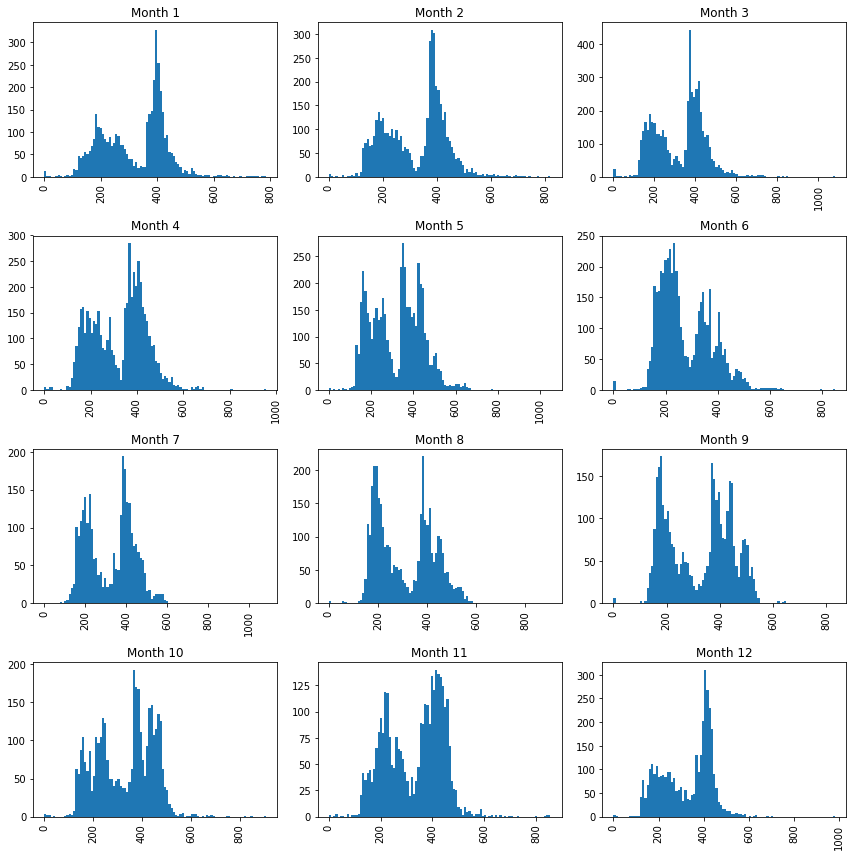

In [23]:
axes = a_grades[a_grades.GRADE_DATE.dt.year < 2018].TIME_AT_GRADE.dt.days.hist(by=a_grades.GRADE_DATE.dt.month, bins=100, figsize=(12,12))
for mo, ax in enumerate(axes.ravel()):
    ax.set_title("Month {}".format(mo + 1))
plt.tight_layout()


## Bi-modal across restaurants that received many grades?

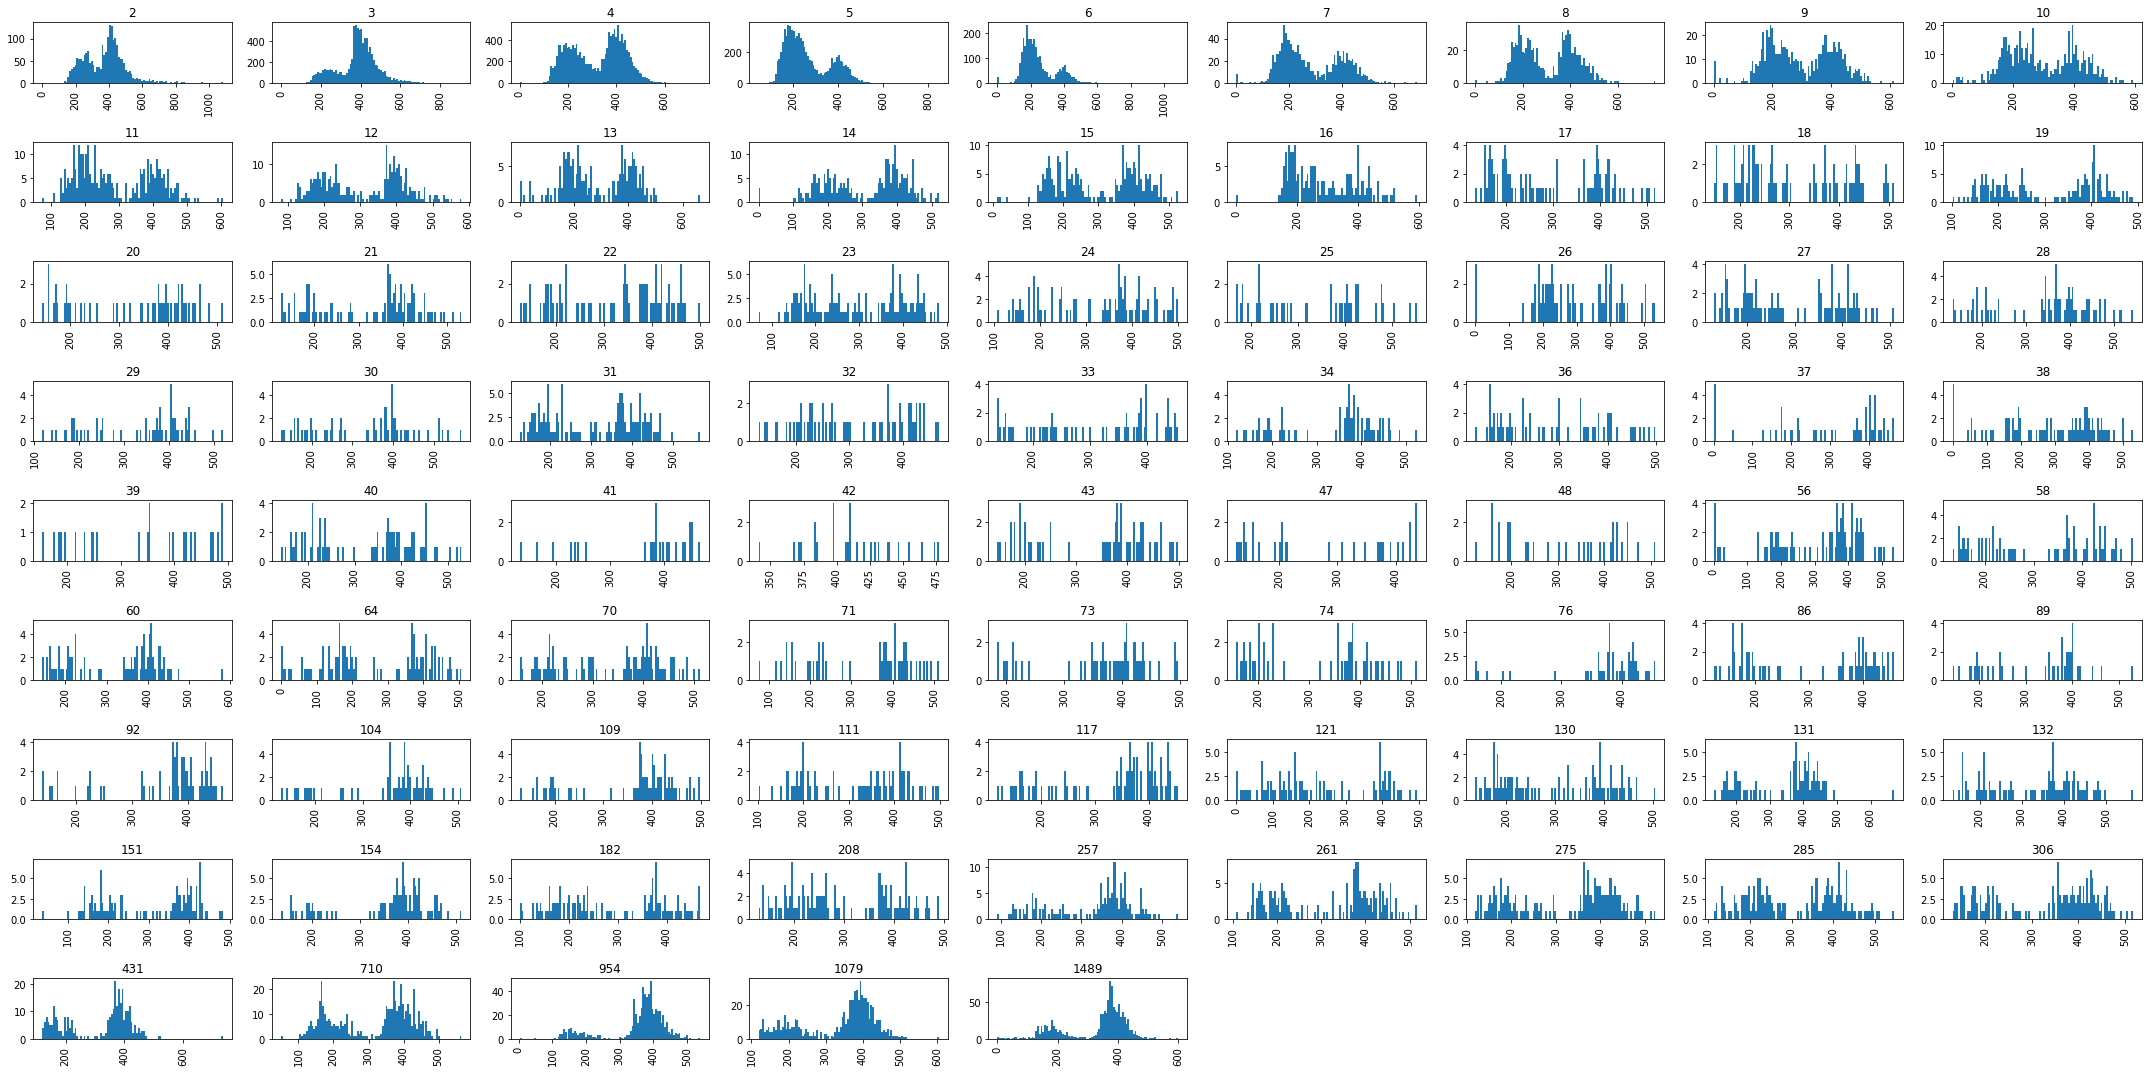

In [24]:
_ = a_grades.TIME_AT_GRADE.dt.days.hist(by=a_grades.NUM_SCORE_DBA, bins=100, figsize=(30,15))
plt.tight_layout()

Text(0,0.5,'Time at A grade')

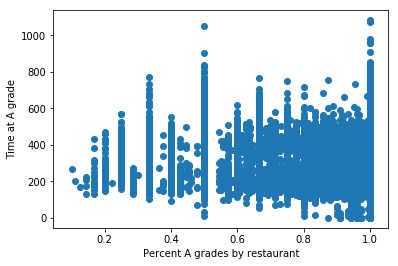

In [25]:
ax = plt.scatter(a_grades.GRADE_A, a_grades.TIME_AT_GRADE.dt.days)
plt.xlabel("Percent A grades by restaurant")
plt.ylabel("Time at A grade")

## Bi-modal across Starbucks?

Text(0.5,0,'Time and A grade')

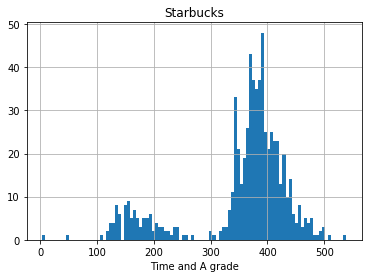

In [26]:
ax = a_grades[a_grades.DBA == "STARBUCKS"].TIME_AT_GRADE.dt.days.hist(bins=100)
ax.set_title("Starbucks")
ax.set_xlabel("Time and A grade")

## Bi-modal across restaurants that always received A grades?

Text(0.5,1,'Always A-graded restaurant')

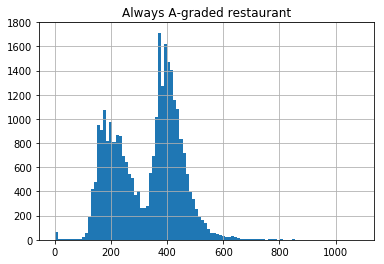

In [27]:
ax = a_grades[(a_grades.GRADE_A == 1)].TIME_AT_GRADE.dt.days.hist(bins=100)
ax.set_title("Always A-graded restaurant")